In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l


In [2]:
n_train,n_test,num_inputs = 20,100,200
true_w,true_b = torch.ones(num_inputs,1)*0.01,0.05
features = torch.randn((n_train + n_test,num_inputs))
labels = torch.matmul(features,true_w,) + true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float)
train_features,test_features = features[:n_train,:],features[n_train:,:]
train_labels,test_labels = labels[:n_train],labels[n_train:]

In [3]:
def init_params():
    w = torch.randn((num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

In [4]:
def l2_penalty(w):
    return (w**2).sum() / 2

In [10]:
batch_size,num_epochs,lr = 1,100,0.003
net,loss = d2l.linreg,d2l.squared_loss
dataset = torch.utils.data.TensorDataset(train_features,train_labels)
train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
def fit_and_plot(lambd):
    w,b = init_params()
    train_ls,test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X,w,b),y) + lambd * l2_penalty(w)
            l = l.sum()
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w,b],lr,batch_size)
        train_ls.append(loss(net(train_features,w,b),train_labels).mean().item())
        test_ls.append(loss(net(test_features,w,b),test_labels).mean().item())
    d2l.semilogy(range(1,num_epochs + 1),train_ls,'epochs','loss',range(1,num_epochs + 1),test_ls,['train','test'])
    print('L2 norm of w:',w.norm().item())

L2 norm of w: 13.39850902557373


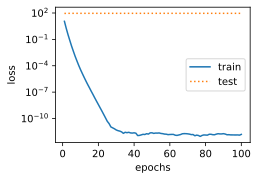

In [11]:
fit_and_plot(lambd=0)#此时是过拟合，没有使用权重衰减

L2 norm of w: 0.041252173483371735


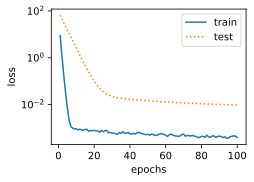

In [12]:
#使用权重衰减
fit_and_plot(lambd=3)

In [13]:
def fit_and_plot_pytorch(wd):
    #权重参数衰减。权重名称一般是以weight结尾
    net = nn.Linear(num_inputs,1)
    nn.init.normal_(net.weight,mean=0,std=1)
    nn.init.normal_(net.bias,mean=0,std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight],lr=lr,weight_decay=wd)#对权重进行衰减
    optimizer_b = torch.optim.SGD(params=[net.bias],lr=lr)#不对偏差进行衰减
    train_ls,test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X),y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            #对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features),train_labels).mean().item())
        test_ls.append(loss(net(test_features),test_labels).mean().item())
    d2l.semilogy(range(1,num_epochs + 1),train_ls,'epochs','loss',range(1,num_epochs + 1),test_ls,['train','test'])
    print('权重的L2正则化',net.weight.data.norm().item())
    

权重的L2正则化 13.305109977722168


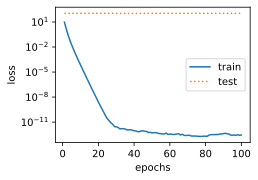

In [14]:
fit_and_plot_pytorch(0)